# Bước 6: Phân cụm khách hàng từ Luật kết hợp (Association Rules → Clustering)

Notebook này lấy **kết quả luật kết hợp** (Apriori/FP-Growth) và biến chúng thành **đặc trưng** để phân cụm khách hàng bằng K-Means.

## Ý tưởng cốt lõi
- Mỗi luật có dạng: **Antecedent → Consequent**
- Với mỗi khách hàng, ta kiểm tra: khách đó đã từng mua **đủ antecedents** của luật hay chưa.
- Mỗi luật trở thành một feature (0/1 hoặc có trọng số theo lift/confidence).
- (Tuỳ chọn) Ghép thêm **RFM** để phân cụm ổn định hơn.


## Parameters
Gán tham số để chạy bằng papermill.


In [1]:
# PARAMETERS (for papermill)

# Input
CLEANED_DATA_PATH = "data/processed/cleaned_uk_data.csv"
RULES_INPUT_PATH = "data/processed/rules_apriori_filtered.csv"  # hoặc rules_fpgrowth_filtered.csv

# Feature engineering
TOP_K_RULES = 30
SORT_RULES_BY = "lift"      # lift | confidence | support
WEIGHTING = "lift"          # none | lift | confidence | support | lift_x_conf
MIN_ANTECEDENT_LEN = 1
USE_RFM = True
RFM_SCALE = True
RULE_SCALE = False

# Clustering
K_MIN = 2
K_MAX = 10
N_CLUSTERS = None            # None => chọn theo silhouette, hoặc đặt số cụ thể (vd 5)
RANDOM_STATE = 42

# Output
OUTPUT_CLUSTER_PATH = "data/processed/customer_clusters_from_rules.csv"

# Visual
PROJECTION_METHOD = "pca"   # pca | svd
PLOT_2D = True
# Parameters
CLEANED_DATA_PATH = "data/processed/cleaned_uk_data.csv"
RULES_INPUT_PATH = "data/processed/rules_apriori_filtered.csv"
TOP_K_RULES = 30
SORT_RULES_BY = "lift"
WEIGHTING = "lift"
MIN_ANTECEDENT_LEN = 1
USE_RFM = True
RFM_SCALE = True
RULE_SCALE = False
K_MIN = 2
K_MAX = 10
N_CLUSTERS = None
RANDOM_STATE = 42
OUTPUT_CLUSTER_PATH = "data/processed/customer_clusters_from_rules.csv"
PROJECTION_METHOD = "pca"
PLOT_2D = True

In [2]:
# Parameters
CLEANED_DATA_PATH = "data/processed/cleaned_uk_data.csv"
RULES_INPUT_PATH = "data/processed/rules_apriori_filtered.csv"
TOP_K_RULES = 30
SORT_RULES_BY = "lift"
WEIGHTING = "lift"
MIN_ANTECEDENT_LEN = 1
USE_RFM = True
RFM_SCALE = True
RULE_SCALE = False
K_MIN = 2
K_MAX = 10
N_CLUSTERS = None
RANDOM_STATE = 42
OUTPUT_CLUSTER_PATH = "data/processed/customer_clusters_from_rules.csv"
PROJECTION_METHOD = "pca"
PLOT_2D = True


## Set up


In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import RuleBasedCustomerClusterer

## Load cleaned data & rules


In [4]:
df_clean = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])
print(df_clean.shape)
df_clean.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_2208\2500469212.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])


(485123, 11)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DayOfWeek,HourOfDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,017850,United Kingdom,15.30,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,017850,United Kingdom,22.00,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8


In [5]:
clusterer = RuleBasedCustomerClusterer(df_clean=df_clean)
customer_item_bool = clusterer.build_customer_item_matrix(threshold=1)
print('Customer × Item:', customer_item_bool.shape)

rules_df = clusterer.load_rules(
    rules_csv_path=RULES_INPUT_PATH,
    top_k=TOP_K_RULES,
    sort_by=SORT_RULES_BY,
)
print('Rules used:', rules_df.shape)
rules_df.head()

Customer × Item: (3921, 4007)
Rules used: (18, 17)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_str,consequents_str,rule_str
0,frozenset({'GREEN REGENCY TEACUP AND SAUCER'}),frozenset({'PINK REGENCY TEACUP AND SAUCER'}),0.051717,0.038955,0.031963,0.618026,15.865302,1.0,0.029948,2.515995,0.988070,0.544423,0.602543,0.719269,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER → PINK REGENCY...
1,frozenset({'PINK REGENCY TEACUP AND SAUCER'}),frozenset({'GREEN REGENCY TEACUP AND SAUCER'}),0.038955,0.051717,0.031963,0.820513,15.865302,1.0,0.029948,5.283289,0.974948,0.544423,0.810724,0.719269,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER → GREEN REGENCY...
2,frozenset({'PINK REGENCY TEACUP AND SAUCER'}),frozenset({'ROSES REGENCY TEACUP AND SAUCER '}),0.038955,0.053049,0.030242,0.776353,14.634584,1.0,0.028176,4.234137,0.969433,0.489668,0.763824,0.673218,PINK REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER → ROSES REGENCY...
3,frozenset({'ROSES REGENCY TEACUP AND SAUCER '}),frozenset({'PINK REGENCY TEACUP AND SAUCER'}),0.053049,0.038955,0.030242,0.570084,14.634584,1.0,0.028176,2.235424,0.983862,0.489668,0.552658,0.673218,ROSES REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER → PINK REGENC...
4,frozenset({'GARDENERS KNEELING PAD CUP OF TEA '}),frozenset({'GARDENERS KNEELING PAD KEEP CALM '}),0.041618,0.049831,0.030021,0.721333,14.475666,1.0,0.027947,3.409698,0.971344,0.488708,0.706719,0.661892,GARDENERS KNEELING PAD CUP OF TEA,GARDENERS KNEELING PAD KEEP CALM,GARDENERS KNEELING PAD CUP OF TEA → GARDENERS...


## Build features (Rules → Features) + (optional) RFM


In [6]:
print("\n1. GIẢI THÍCH THIẾT LẬP FEATURE ENGINEERING:")
print(f"• Số luật sử dụng: TOP_K_RULES = {TOP_K_RULES}")
print(f"• Sắp xếp luật theo: {SORT_RULES_BY}")
print(f"• Weighting method: {WEIGHTING}")
print(f"  - {'none' if WEIGHTING == 'none' else WEIGHTING}: {'Binary features (0/1)' if WEIGHTING == 'none' else 'Features có trọng số'}")
print(f"• Sử dụng RFM: {USE_RFM}")
print(f"• Scale RFM: {RFM_SCALE}")
print(f"• Scale rule features: {RULE_SCALE}")
print(f"• Độ dài antecedent tối thiểu: {MIN_ANTECEDENT_LEN}")

print("\n2. TẠO 2 BIẾN THỂ ĐẶC TRƯNG THEO YÊU CẦU:")

# Biến thể 1: BASELINE - Binary rules (không RFM)
print("\n• Biến thể 1 (Baseline): Binary rules, không RFM")
print("  - Weighting: none (binary 0/1)")
print("  - Use RFM: False")
print("  - Mục đích: Baseline để so sánh")

# Tạo biến thể 1
clusterer_v1 = RuleBasedCustomerClusterer(df_clean=df_clean)
customer_item_bool_v1 = clusterer_v1.build_customer_item_matrix(threshold=1)

rules_df_v1 = clusterer_v1.load_rules(
    rules_csv_path=RULES_INPUT_PATH,
    top_k=TOP_K_RULES,
    sort_by=SORT_RULES_BY,
)

X_v1, meta_v1 = clusterer_v1.build_final_features(
    weighting='none',      # Binary
    use_rfm=False,         # Không RFM
    rfm_scale=False,
    rule_scale=False,
    min_antecedent_len=MIN_ANTECEDENT_LEN,
)

print(f"  - Feature matrix shape: {X_v1.shape}")
print(f"  - Số features: {X_v1.shape[1]}")
# Biến thể 2: NÂNG CAO - Weighted rules + RFM
print("\n• Biến thể 2 (Nâng cao): Weighted rules + RFM")
print(f"  - Weighting: {WEIGHTING} (trọng số theo độ mạnh luật)")
print(f"  - Use RFM: {USE_RFM} (kết hợp giá trị khách hàng)")
print(f"  - RFM Scale: {RFM_SCALE}")
print(f"  - Rule Scale: {RULE_SCALE}")
print(f"  - Mục đích: Kết hợp hành vi mua kèm + giá trị khách hàng")

# Tạo biến thể 2
clusterer = RuleBasedCustomerClusterer(df_clean=df_clean)
customer_item_bool = clusterer.build_customer_item_matrix(threshold=1)

rules_df = clusterer.load_rules(
    rules_csv_path=RULES_INPUT_PATH,
    top_k=TOP_K_RULES,
    sort_by=SORT_RULES_BY,
)

X, meta = clusterer.build_final_features(
    weighting=WEIGHTING,
    use_rfm=USE_RFM,
    rfm_scale=RFM_SCALE,
    rule_scale=RULE_SCALE,
    min_antecedent_len=MIN_ANTECEDENT_LEN,
)

print(f"  - Feature matrix shape: {X.shape}")
print(f"  - Số features: {X.shape[1]}")


1. GIẢI THÍCH THIẾT LẬP FEATURE ENGINEERING:
• Số luật sử dụng: TOP_K_RULES = 30
• Sắp xếp luật theo: lift
• Weighting method: lift
  - lift: Features có trọng số
• Sử dụng RFM: True
• Scale RFM: True
• Scale rule features: False
• Độ dài antecedent tối thiểu: 1

2. TẠO 2 BIẾN THỂ ĐẶC TRƯNG THEO YÊU CẦU:

• Biến thể 1 (Baseline): Binary rules, không RFM
  - Weighting: none (binary 0/1)
  - Use RFM: False
  - Mục đích: Baseline để so sánh


  - Feature matrix shape: (3921, 18)
  - Số features: 18

• Biến thể 2 (Nâng cao): Weighted rules + RFM
  - Weighting: lift (trọng số theo độ mạnh luật)
  - Use RFM: True (kết hợp giá trị khách hàng)
  - RFM Scale: True
  - Rule Scale: False
  - Mục đích: Kết hợp hành vi mua kèm + giá trị khách hàng


  - Feature matrix shape: (3921, 21)
  - Số features: 21


## Choose K (silhouette)


In [7]:
# Chọn K cho biến thể 1
print("\n• Biến thể 1 (Baseline):")
sil_df_v1 = clusterer_v1.choose_k_by_silhouette(
    X_v1,
    k_min=K_MIN,
    k_max=K_MAX,
    random_state=RANDOM_STATE,
)
print(sil_df_v1.head(3))

best_k_v1 = int(sil_df_v1.loc[0, 'k'])
best_sil_v1 = sil_df_v1.loc[0, 'silhouette']
print(f"  - K tốt nhất theo silhouette: {best_k_v1} (score: {best_sil_v1:.3f})")

# Chọn K cho biến thể 2
print("\n• Biến thể 2 (Nâng cao):")
sil_df = clusterer.choose_k_by_silhouette(
    X,
    k_min=K_MIN,
    k_max=K_MAX,
    random_state=RANDOM_STATE,
)
print("\nSilhouette scores cho biến thể 2:")

print(sil_df.head(3))

best_k_v2 = int(sil_df.loc[0, 'k'])
best_sil_v2 = sil_df.loc[0, 'silhouette']
print(f"  - K tốt nhất theo silhouette: {best_k_v2} (score: {best_sil_v2:.3f})")


• Biến thể 1 (Baseline):


    k  silhouette
0  10    0.655753
1   7    0.655066
2   3    0.650291
  - K tốt nhất theo silhouette: 10 (score: 0.656)

• Biến thể 2 (Nâng cao):



Silhouette scores cho biến thể 2:
   k  silhouette
0  2    0.758771
1  5    0.647983
2  4    0.618838
  - K tốt nhất theo silhouette: 2 (score: 0.759)


In [8]:
# Xem xét các ứng viên K
k_candidates = [best_k_v1, best_k_v2]
print(f"• Ứng viên K từ 2 biến thể: {k_candidates}")

# Ưu tiên K trong khoảng 3-6 (ý nghĩa marketing tốt)
suitable_ks = [k for k in k_candidates if 3 <= k <= 6]

if suitable_ks:
    chosen_k = suitable_ks[0]  # Lấy K đầu tiên trong khoảng phù hợp
    print(f"• Chọn K={chosen_k} (nằm trong khoảng 3-6, phù hợp cho segmentation marketing)")
elif N_CLUSTERS is not None:
    chosen_k = N_CLUSTERS
    print(f"• Dùng K cố định từ param: {chosen_k}")
else:
    # Chọn K có silhouette cao nhất
    if best_sil_v1 >= best_sil_v2:
        chosen_k = best_k_v1
        print(f"• Chọn K={chosen_k} từ biến thể 1 (silhouette cao hơn: {best_sil_v1:.3f})")
    else:
        chosen_k = best_k_v2
        print(f"• Chọn K={chosen_k} từ biến thể 2 (silhouette cao hơn: {best_sil_v2:.3f})")

print(f"• Quyết định cuối cùng: K = {chosen_k}")

• Ứng viên K từ 2 biến thể: [10, 2]
• Chọn K=2 từ biến thể 2 (silhouette cao hơn: 0.759)
• Quyết định cuối cùng: K = 2


## Fit KMeans & save results


In [9]:
# So sánh silhouette của 2 biến thể
if best_sil_v1 >= best_sil_v2:
    print(f"• Biến thể 1 (Baseline) có silhouette cao hơn ({best_sil_v1:.3f} vs {best_sil_v2:.3f})")
    best_clusterer = clusterer_v1
    best_X = X_v1
    best_meta = meta_v1
    best_variant = "Baseline (Binary rules, no RFM)"
else:
    print(f"• Biến thể 2 (Nâng cao) có silhouette cao hơn ({best_sil_v2:.3f} vs {best_sil_v1:.3f})")
    best_clusterer = clusterer
    best_X = X
    best_meta = meta
    best_variant = f"Nâng cao (Weighted={WEIGHTING}, RFM={USE_RFM})"

print(f"• Sử dụng biến thể: {best_variant}")

# Huấn luyện K-Means với K đã chọn
print(f"• Huấn luyện K-Means với K={chosen_k}...")
labels = best_clusterer.fit_kmeans(best_X, n_clusters=chosen_k, random_state=RANDOM_STATE)

# Tính silhouette score cuối cùng
from sklearn.metrics import silhouette_score
final_sil_score = silhouette_score(best_X, labels) if chosen_k > 1 else 0
print(f"• Silhouette score cuối cùng: {final_sil_score:.3f}")

# Lưu kết quả
meta_out = best_meta.copy()
meta_out['cluster'] = labels

os.makedirs(os.path.dirname(OUTPUT_CLUSTER_PATH), exist_ok=True)
meta_out.to_csv(OUTPUT_CLUSTER_PATH, index=False)
print(f"• Đã lưu kết quả: {OUTPUT_CLUSTER_PATH}")
comparison_data = []
comparison_data.append({
    'Biến thể': '1. Baseline',
    'Mô tả': 'Binary rules, no RFM',
    'K tốt nhất': best_k_v1,
    'Silhouette': f"{best_sil_v1:.3f}",
    'Số features': X_v1.shape[1],
    'Weighting': 'none',
    'RFM': 'Không',
    'Được chọn': '✓' if best_sil_v1 >= best_sil_v2 else ''
})

comparison_data.append({
    'Biến thể': '2. Nâng cao',
    'Mô tả': f'Weighted ({WEIGHTING}) + RFM',
    'K tốt nhất': best_k_v2,
    'Silhouette': f"{best_sil_v2:.3f}",
    'Số features': X.shape[1],
    'Weighting': WEIGHTING,
    'RFM': 'Có',
    'Được chọn': '✓' if best_sil_v2 > best_sil_v1 else ''
})

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "-" * 100)
print(comparison_df.to_string(index=False))
print("-" * 100)

print(f"\nKẾT LUẬN: Biến thể {'Baseline' if best_sil_v1 >= best_sil_v2 else 'Nâng cao'} được chọn vì có silhouette cao hơn.")

• Biến thể 2 (Nâng cao) có silhouette cao hơn (0.759 vs 0.656)
• Sử dụng biến thể: Nâng cao (Weighted=lift, RFM=True)
• Huấn luyện K-Means với K=2...


• Silhouette score cuối cùng: 0.759
• Đã lưu kết quả: data/processed/customer_clusters_from_rules.csv

----------------------------------------------------------------------------------------------------
   Biến thể                 Mô tả  K tốt nhất Silhouette  Số features Weighting   RFM Được chọn
1. Baseline  Binary rules, no RFM          10      0.656           18      none Không          
2. Nâng cao Weighted (lift) + RFM           2      0.759           21      lift    Có         ✓
----------------------------------------------------------------------------------------------------

KẾT LUẬN: Biến thể Nâng cao được chọn vì có silhouette cao hơn.


## Quick profiling


In [10]:
profile_cols = ['cluster'] + ([c for c in ['Recency','Frequency','Monetary'] if c in meta_out.columns])
summary = meta_out.groupby('cluster').agg({
    'CustomerID': 'count',
    **{c:'mean' for c in profile_cols if c!='cluster'}
}).rename(columns={'CustomerID':'n_customers'}).sort_values('n_customers', ascending=False)

print("\nThống kê theo cụm:")
print(summary)


Thống kê theo cụm:
         n_customers    Recency  Frequency      Monetary
cluster                                                 
0               3623  94.530500   3.854264   1646.203242
1                298  63.671141  13.614094  10271.905168


## 2D visualization (PCA/SVD)



8. TRỰC QUAN HÓA PHÂN CỤM:


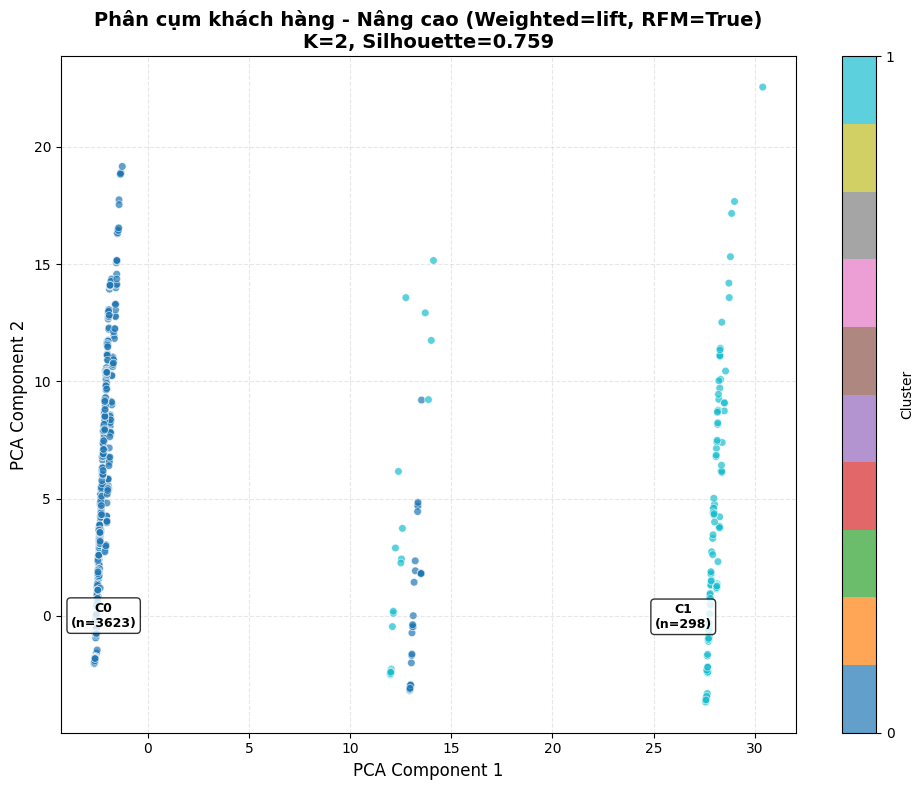


NHẬN XÉT BIỂU ĐỒ:
--------------------------------------------------
• Các cụm TÁCH BIỆT RÕ RÀNG:
  - Có thể thấy các nhóm màu riêng biệt
  - Khoảng cách giữa các cụm đủ lớn
  → Phân cụm có chất lượng tốt, dễ phân biệt segments

• Số cụm: 2
• Phương pháp giảm chiều: PCA
• Biến thể sử dụng: Nâng cao (Weighted=lift, RFM=True)
• Silhouette score: 0.759


In [11]:
if PLOT_2D:
    print("\n8. TRỰC QUAN HÓA PHÂN CỤM:")
        
    Z = best_clusterer.project_2d(best_X, method=PROJECTION_METHOD, random_state=RANDOM_STATE)
        
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(Z[:, 0], Z[:, 1], 
                        c=labels, 
                        cmap='tab10', 
                        s=30, 
                        alpha=0.7,
                        edgecolors='w', 
                        linewidth=0.5)
        
    plt.title(f'Phân cụm khách hàng - {best_variant}\nK={chosen_k}, Silhouette={final_sil_score:.3f}', 
            fontsize=14, fontweight='bold')
    plt.xlabel(f'{PROJECTION_METHOD.upper()} Component 1', fontsize=12)
    plt.ylabel(f'{PROJECTION_METHOD.upper()} Component 2', fontsize=12)
    plt.colorbar(scatter, label='Cluster', ticks=range(chosen_k))
    plt.grid(True, alpha=0.3, linestyle='--')
        
    # Thêm số lượng điểm cho mỗi cluster
    for cluster_id in range(chosen_k):
        cluster_points = Z[labels == cluster_id]
        if len(cluster_points) > 0:
            center = cluster_points.mean(axis=0)
            plt.annotate(f'C{cluster_id}\n(n={len(cluster_points)})', 
                        xy=center, 
                        xytext=(center[0], center[1]),
                        ha='center', 
                        va='center',
                        fontsize=9,
                        fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
    plt.tight_layout()
    plt.show()
        
    # NHẬN XÉT CỤ THỂ VỀ BIỂU ĐỒ
    print("\nNHẬN XÉT BIỂU ĐỒ:")
    print("-" * 50)
        
    if final_sil_score > 0.5:
        print("• Các cụm TÁCH BIỆT RÕ RÀNG:")
        print("  - Có thể thấy các nhóm màu riêng biệt")
        print("  - Khoảng cách giữa các cụm đủ lớn")
        print("  → Phân cụm có chất lượng tốt, dễ phân biệt segments")
    elif final_sil_score > 0.25:
        print("• Các cụm CÓ CHỒNG LẤN MỘT PHẦN:")
        print("  - Một số điểm nằm ở vùng giao thoa giữa các cụm")
        print("  - Vẫn có thể phân biệt được trung tâm các cụm")
        print("  → Phân cụm chấp nhận được, cần kiểm tra thêm qua profiling")
    else:
        print("• Các cụm CHỒNG LẤN NHIỀU:")
        print("  - Các điểm trộn lẫn với nhau")
        print("  - Khó phân biệt ranh giới giữa các cụm")
        print("  → Chất lượng phân cụm thấp, cần xem xét lại features hoặc K")
        
    # Phân tích cụ thể từ hình ảnh
    print(f"\n• Số cụm: {chosen_k}")
    print(f"• Phương pháp giảm chiều: {PROJECTION_METHOD.upper()}")
    print(f"• Biến thể sử dụng: {best_variant}")
    print(f"• Silhouette score: {final_sil_score:.3f}")